<a href="https://colab.research.google.com/github/Aakanksha0511/SelfProjects/blob/main/Segcityparis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose,MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate,Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [ ]:
from keras import backend as K  
#tf.keras.backend.set_image_data_format(data_format)
K.set_image_data_format('channels_last')

In [ ]:
def LoadImage(name, path="../content/drive/MyDrive/Cityofparis/cityscapes_data/train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 256)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

In [ ]:
files =os.listdir("../content/drive/MyDrive/Cityofparis/cityscapes_data/train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

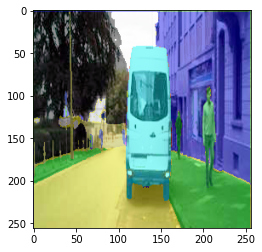

In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("174.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

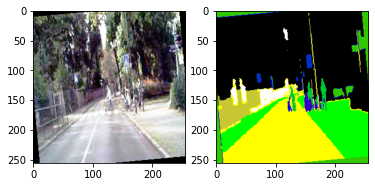

In [ ]:
def Generate(path="../content/drive/MyDrive/Cityofparis/cityscapes_data/train", batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

In [ ]:
inp = Input(shape=(256, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)


opt = Adam(lr=0.000001)
model.compile(optimizer=opt,
             loss="mean_squared_error",
             metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 1179776     conv2d[0][0]                     
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
base_filter_num=64
inputs = Input(shape= (256, 256, 3))
conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_0)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
 
conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_0)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
 
up1_0 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_0)
merge00_10 = concatenate([conv0_0,up1_0])
conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge00_10)
conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_1)
 
conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_0)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
 
up2_0 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_0)
merge10_20 = concatenate([conv1_0,up2_0])
conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_20)
conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
 
up1_1 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_1)
merge01_11 = concatenate([conv0_0,conv0_1,up1_1])
conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge01_11)
conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_2)
 
conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_0)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
 
up3_0 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_0)
merge20_30 = concatenate([conv2_0,up3_0])
conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge20_30)
conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
 
up2_1 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_1)
merge11_21 = concatenate([conv1_0,conv1_1,up2_1])
conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11_21)
conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)
 
up1_2 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_2)
merge02_12 = concatenate([conv0_0,conv0_1,conv0_2,up1_2])
conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge02_12)
conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_3)
 
conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_0)
 
up4_0 = Conv2DTranspose(base_filter_num*8, (2, 2), strides=(2, 2), padding='same')(conv4_0)
merge30_40 = concatenate([conv3_0,up4_0])
conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge30_40)
conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
 
up3_1 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_1)
merge21_31 = concatenate([conv2_0,conv2_1,up3_1])
conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge21_31)
conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)
 
up2_2 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_2)
merge12_22 = concatenate([conv1_0,conv1_1,conv1_2,up2_2])
conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12_22)
conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_3)
 
up1_3 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_3)
merge03_13 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up1_3])
conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)

conv0_4 = Conv2D(13,1, activation = 'softmax')(conv0_4)
 
model_1= Model(inputs = inputs, outputs = conv0_4)
opt = Adam(lr=0.0001)
model_1.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_15[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D()(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D()(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D()(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D()(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4])
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3])
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2])
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1])
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(13, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])
model_2 = unet()
opt = Adam(lr=0.000001)
model_2.compile(optimizer=opt,
             loss="'mean_squared_error'",
             metrics=["accuracy"])
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 36928       activation[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_gen = Generate()
val_gen = Generate("../content/drive/MyDrive/Cityofparis/cityscapes_data/train")

In [ ]:
clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]
h = model.fit_generator(train_gen, epochs=650, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/650
10/10 [==============================] - 208s 15s/step - loss: 0.0583 - accuracy: 0.0269 - val_loss: 0.0589 - val_accuracy: 0.0188
Epoch 2/650
10/10 [==============================] - 133s 14s/step - loss: 0.0593 - accuracy: 0.0379 - val_loss: 0.0592 - val_accuracy: 0.0242
Epoch 3/650
10/10 [==============================] - 135s 14s/step - loss: 0.0586 - accuracy: 0.0536 - val_loss: 0.0598 - val_accuracy: 0.0355
Epoch 4/650
10/10 [==============================] - 122s 13s/step - loss: 0.0588 - accuracy: 0.0684 - val_loss: 0.0581 - val_accuracy: 0.0407
Epoch 5/650
10/10 [==============================] - 117s 12s/step - loss: 0.0583 - accuracy: 0.0757 - val_loss: 0.0590 - val_accuracy: 0.0545
Epoch 6/650
10/10 [==============================] - 119s 13s/step - loss: 0.0585 - accuracy: 0.0921 - val_loss: 0.0590 - val_accuracy: 0.1062
Epoch 7/650
10/10 [==============================] - 118s 12s/step - loss: 0.0590 - accuracy: 0.1304 - val_loss: 0.0605 - val_accuracy: 0.1303

In [ ]:
model.save("bestmodel.h5")
model = load_model("loss.h5")
model_1.save("model_1.h5")
model_1 = load_model("loss.h5")
model_2.save("bestmodel_1.h5")
model_2 = load_model("loss.h5")

In [ ]:
val_loss = h.history["val_loss"]
val_acc = h.history["val_accuracy"]
loss=h.history["loss"]
acc=h.history["accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Loss Graph",fontsize = 15)
plot.plot(loss, 'b-')
plot.plot(val_loss,'r-')
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Accuracy Graph",fontsize = 15)
plot.plot(acc, 'b-')
plot.plot(val_acc,'r-')
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

In [ ]:
val_loss = h.history["val_loss"]
val_acc = h.history["val_accuracy"]
loss_1=h.history["loss"]
acc_1=h.history["accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Loss Graph",fontsize = 15)
plot.plot(loss_1, 'b-')
plot.plot(val_loss,'r-')
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Accuracy Graph",fontsize = 15)
plot.plot(acc_1, 'b-')
plot.plot(val_acc,'r-')
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn_1.png", dpi=150)
plot.show()

In [ ]:
val_loss = h.history["val_loss"]
val_acc = h.history["val_accuracy"]
loss_2=h.history["loss"]
acc_2=h.history["accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Loss Graph",fontsize = 15)
plot.plot(loss_2, 'b-')
plot.plot(val_loss,'r-')
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Accuracy Graph",fontsize = 15)
plot.plot(acc_2, 'b-')
plot.plot(val_acc,'r-')
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn_2.png", dpi=150)
plot.show()

In [ ]:
plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Loss Graph",fontsize = 15)
plot.plot(loss, 'b-')
plot.plot(loss_1,'r-')
plot.plot(loss_2,'g-')
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Accuracy Graph",fontsize = 15)
plot.plot(acc, 'b-')
plot.plot(acc_1,'r-')
plot.plot(acc_2,'g-')
plot.xlabel("Epoch")
plot.ylabel("Accuracy")
plot.tight_layout()

In [ ]:
test_gen = Generate("../content/drive/MyDrive/Cityofparis/cityscapes_data/val")
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate("../content/drive/MyDrive/Cityofparis/cityscapes_data/val", batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("bas.png")
plot.show()